In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import seaborn as sns; 
tfd = tf.contrib.distributions
import imageio
import glob
import tensorflow_probability as tfp
tfd = tfp.distributions
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print(tf.__version__)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

1.14.0


In [69]:
tf.reset_default_graph()


mx = tf.Variable([-5.,0.,0.],name='mx')
low = [mx[0] - 3,mx[1] - 3,mx[2]-1e-6]
high = [mx[0] + 3,mx[1] + 3,mx[2]+1e-6]
p_x = tfd.TruncatedNormal(loc=mx,scale=1.,low=low, high=high)
# p_x = tfd.Normal(loc=mx, scale=1.)

m = tf.Variable([5.,0., 0],name='m')
low_m = [m[0] - 3, m[1] - 3, m[2]-1e-6]
high_m = [m[0] + 3, m[1] + 3, m[2]+1e-6]
q = tfd.TruncatedNormal(loc=m,scale=1.,low=low_m, high=high_m)
# q = tfd.Normal(loc=m, scale=1.)

mu_ = tf.Variable([0.,0., 0.])
sigma_ = 1*tf.Variable([10., 1., 1.])
base = tfd.Normal(loc=mu_, scale=sigma_)

samples = base.sample([512]) 
p_samples = p_x.sample([200])
q_samples = q.sample([200])

pd = tf.reduce_mean(tf.square((p_x.prob(q_samples)/q.prob(q_samples)) - 1)) #pearson div
kld = tf.reduce_mean( tf.log(q.prob(q_samples) + 1e-10) - tf.log(p_x.prob(q_samples) + 1e-10) ) #kl div

ratio_p = p_x.prob(samples)/base.prob(samples) 
ratio_q = q.prob(samples)/base.prob(samples)


# sbd = tf.reduce_mean( tf.square(ratio_p - 1) - tf.square(ratio_q - 1) - 2*(ratio_q-1)*(ratio_p-ratio_q) )
alpha=np.array([0.5],dtype="float32") 
sbd = tf.reduce_mean( (tf.pow(ratio_p+1e-5,alpha) - tf.pow(ratio_q+1e-5,alpha) - alpha*tf.pow(ratio_q+1e-5,(alpha-1))*(ratio_p-ratio_q)) )/(alpha*(alpha-1))

t_vars = tf.trainable_variables()

opt = tf.train.AdamOptimizer(learning_rate=1e-2)
train = opt.minimize(sbd, var_list=[m])
init = tf.global_variables_initializer()

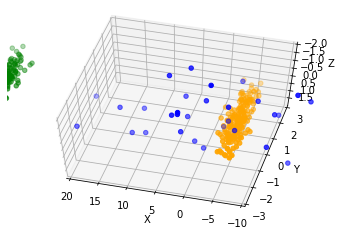

In [70]:
batch_s = 200
batch_sample = 200

# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
kld_store=[]
pd_store=[]
sbd_store=[]


fig = plt.figure()        
ax = plt.axes(projection='3d')


for i in range(0, 10000):
    
    m_,sig1_,m__,sig__ = sess.run([low,high,low_m,high_m])
    # Train
    feed_dict = {}
    kl, pd_, sbd_, p_s,q_s,s,_ = sess.run([kld, pd, sbd, p_samples,q_samples, samples,train],feed_dict=feed_dict)
    kld_store.append(kl)
    pd_store.append(pd_)
    sbd_store.append(sbd_)
    
    if i%1000==0:
        ax.clear()
        scat_o = ax.scatter(p_s[:200,0],p_s[:200,1],p_s[:200,2],color='orange')
        scat_g = ax.scatter(q_s[:200,0],q_s[:200,1],q_s[:200,2],color='green')

        ax.scatter(s[:30,0],s[:30,1],s[:30,2],color='blue') 
        
#         sns.kdeplot(p_s[:,0],p_s[:,1],cmap="Reds", shade=True, shade_lowest=False,ax=ax)
#         sns.kdeplot(q_s[:,0],q_s[:,1],cmap="Greens", shade=True, shade_lowest=False,ax=ax)

        ax.view_init(-120, 75)
        
        plt.xlim(-10,20) 
        plt.ylim(-3,3) 
        
        
#         Add the labels
        ax.set_xlabel('X' )
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.grid(True)
        filename='fig/step'+str(i)+'.png'
        plt.savefig(filename, dpi=96)
        plt.gca()

filenames = sorted(glob.glob("fig/*.png"))
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('anim.gif', images, duration=1)

![Animation](anim.gif)

In [71]:
print(sbd_store[:10])

[array([199.95891], dtype=float32), array([211.41035], dtype=float32), array([232.74806], dtype=float32), array([210.79466], dtype=float32), array([221.22334], dtype=float32), array([184.22688], dtype=float32), array([187.2817], dtype=float32), array([232.16313], dtype=float32), array([167.85664], dtype=float32), array([236.44255], dtype=float32)]


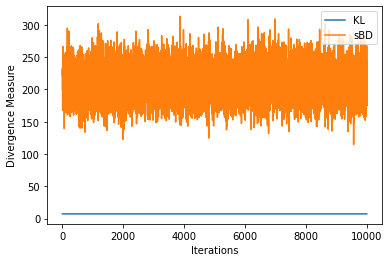

In [72]:
plt.plot(kld_store[:],label='KL')
# plt.plot(pd_store[:],label='PD')
plt.plot(sbd_store[:],label='sBD')
plt.xlabel("Iterations")
plt.ylabel("Divergence Measure")
plt.legend(loc='upper right')

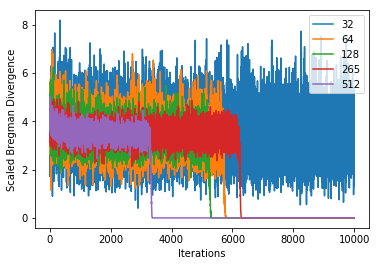

In [14]:
plt.plot(sbd_store10[:],label='32')
plt.plot(sbd_store[:],label='64')
plt.plot(sbd_store5[:],label='128')
plt.plot(sbd_store6[:],label='265')
plt.plot(sbd_store7[:],label='512')
plt.xlabel("Iterations")
plt.ylabel("Scaled Bregman Divergence")
plt.legend(loc='upper right')